In [62]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram
from constants import MASS_BINS

In [63]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey (this is the main one)
galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters
# clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eRASS/dr1_clusters_optical/eRASS1_clusters_optical.fits')[1].data  # clusters

print('number of galaxies: ', len(sciencegkv_galaxies_raw))
print('number of galaxies: ', len(galaxies_raw))
print('number of the clusters: ', len(clusters_raw))

number of galaxies:  2232985
number of galaxies:  370116
number of the clusters:  542


In [64]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['Z'] < 0.4) &
    # (sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['RAcen'] > 129.0) &
    (sciencegkv_galaxies_raw['RAcen'] < 141.0) &
    (sciencegkv_galaxies_raw['Deccen'] > -2.0) &
    (sciencegkv_galaxies_raw['Deccen'] < 3.0)&
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == False) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['Z'] < 0.4) &
        (galaxies_raw['flux_rt'] >= 5.011928e-05) &
        (galaxies_raw['RAcen'] > 129.0) &
        (galaxies_raw['RAcen'] < 141.0) &
        (galaxies_raw['Deccen'] > -2.0) &
        (galaxies_raw['Deccen'] < 3.0)
)

# cluster masks
cluster_mask = (
        # ~np.isnan(clusters_raw['VDISP']) &  # mask clusters which don't have VDISP values
        ~np.isnan(clusters_raw['VDISP']) &  # mask clusters which don't have VDISP values
        (clusters_raw['RA'] > 128.5007) &
        (clusters_raw['RA'] < 141.5) &
        (clusters_raw['DEC'] > -2.05) &
        (clusters_raw['DEC'] < 3.02)
)



big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]
print('number of the galaxies in big survey after masking: ', len(big_galaxy_catalog))
print('number of the galaxies in small survey after masking: ', len(galaxy_catalog))
print('number of the clusters after masking: ', len(cluster_catalog))


number of the galaxies in big survey after masking:  47105
number of the galaxies in small survey after masking:  45520
number of the clusters after masking:  162


In [27]:
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"
print(completeness_region_df.head())

/media/farnoosh/LMU/nextcloud/jupyternotebooks/erosita_DR1/completeness.py:54: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [40]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['ZBEST'].byteswap().newbyteorder(),
    'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),
    'VDISP_error': cluster_catalog['VDISP_ERR'].byteswap().newbyteorder()
})



# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder()
})

print(galaxy_df)

                uberID          RA       DEC        z         mstar
0      138021052006945  137.992346  2.570577  0.21327  3.294812e+10
1      131010293406270  131.307189  1.507075  0.20730  1.506049e+10
2      136000563202354  136.053008  0.138277  0.27538  5.989433e+10
3      130020205007803  130.790764  2.651356  0.29370  9.169161e+10
4      130990151906125  131.440319 -0.506608  0.15497  4.314327e+10
...                ...         ...       ...      ...           ...
45515  130990634008739  130.986376 -0.260436  0.26954  2.591990e+10
45516  135021016609990  135.025604  2.857325  0.19924  3.190467e+10
45517  135000832810514  134.799377  0.906732  0.02531  9.149594e+07
45518  140000362709494  140.241766  0.810503  0.02381  1.054762e+08
45519  137021074202062  136.971637  2.110832  0.27823  6.388143e+10

[45520 rows x 5 columns]


In [31]:
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)
print(matched_galaxy_dataframe[matched_galaxy_dataframe['environment'] != 'Field'].head())

Progress: 99.99780316344464%%%%%

In [37]:
print(matched_galaxy_dataframe)

                uberID          RA       DEC        z         mstar  \
0      138021052006945  137.992346  2.570577  0.21327  3.294812e+10   
1      131010293406270  131.307189  1.507075  0.20730  1.506049e+10   
2      136000563202354  136.053008  0.138277  0.27538  5.989433e+10   
3      130020205007803  130.790764  2.651356  0.29370  9.169161e+10   
4      130990151906125  131.440319 -0.506608  0.15497  4.314327e+10   
...                ...         ...       ...      ...           ...   
45515  130990634008739  130.986376 -0.260436  0.26954  2.591990e+10   
45516  135021016609990  135.025604  2.857325  0.19924  3.190467e+10   
45517  135000832810514  134.799377  0.906732  0.02531  9.149594e+07   
45518  140000362709494  140.241766  0.810503  0.02381  1.054762e+08   
45519  137021074202062  136.971637  2.110832  0.27823  6.388143e+10   

         environment cluster_mass           cluster_name  
0              Field         None                   None  
1              Field         

In [49]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner" , on="uberID")
print(merged_galaxy_df[merged_galaxy_df["environment"] != "Field"])

                uberID  completeness region          RA       DEC        z  \
4      130990151906125      0.958461    G09  131.440319 -0.506608  0.15497   
103    130990156606252      0.957437    G09  131.435755 -0.494546  0.15614   
115    133990088904009      0.960953    G09  134.499717 -0.705824  0.24617   
120    130990157106322      0.965963    G09  131.435501 -0.488441  0.15490   
163    140000375308747      0.851646    G09  140.229955  0.740357  0.15914   
...                ...           ...    ...         ...       ...      ...   
45245  130990136705562      0.962619    G09  131.454678 -0.559571  0.15442   
45263  132020164006107      0.926247    G09  132.829446  2.491626  0.38500   
45300  136991087411411      0.965435    G09  136.559441 -0.008810  0.19930   
45470  130990148605975      0.963208    G09  131.443428 -0.520688  0.15834   
45488  130990149606322      0.964371    G09  131.442491 -0.487985  0.15737   

              mstar    environment cluster_mass           clust

In [51]:
# get the mass histograms (galaxy mass function) and errors

# get the histogram for all galaxies
mass_histogram_all_galaxies, mass_histogram_all_galaxies_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df, region_name="G09")

# get the histogram for all galaxies in the field
mass_histogram_field_only, mass_histogram_field_only_errors = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "Field"], region_name="G09")

# get the histogram for all galaxies which are cluster members
mass_histogram_cluster_members, mass_histogram_cluster_members_error = get_weighted_mass_histogram(input_mass_completeness_dataframe=merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"], region_name="G09")

<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_20419/4090217487.py:29: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)', fontsize=16)
/tmp/ipykernel_20419/4090217487.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)', fontsize=16)


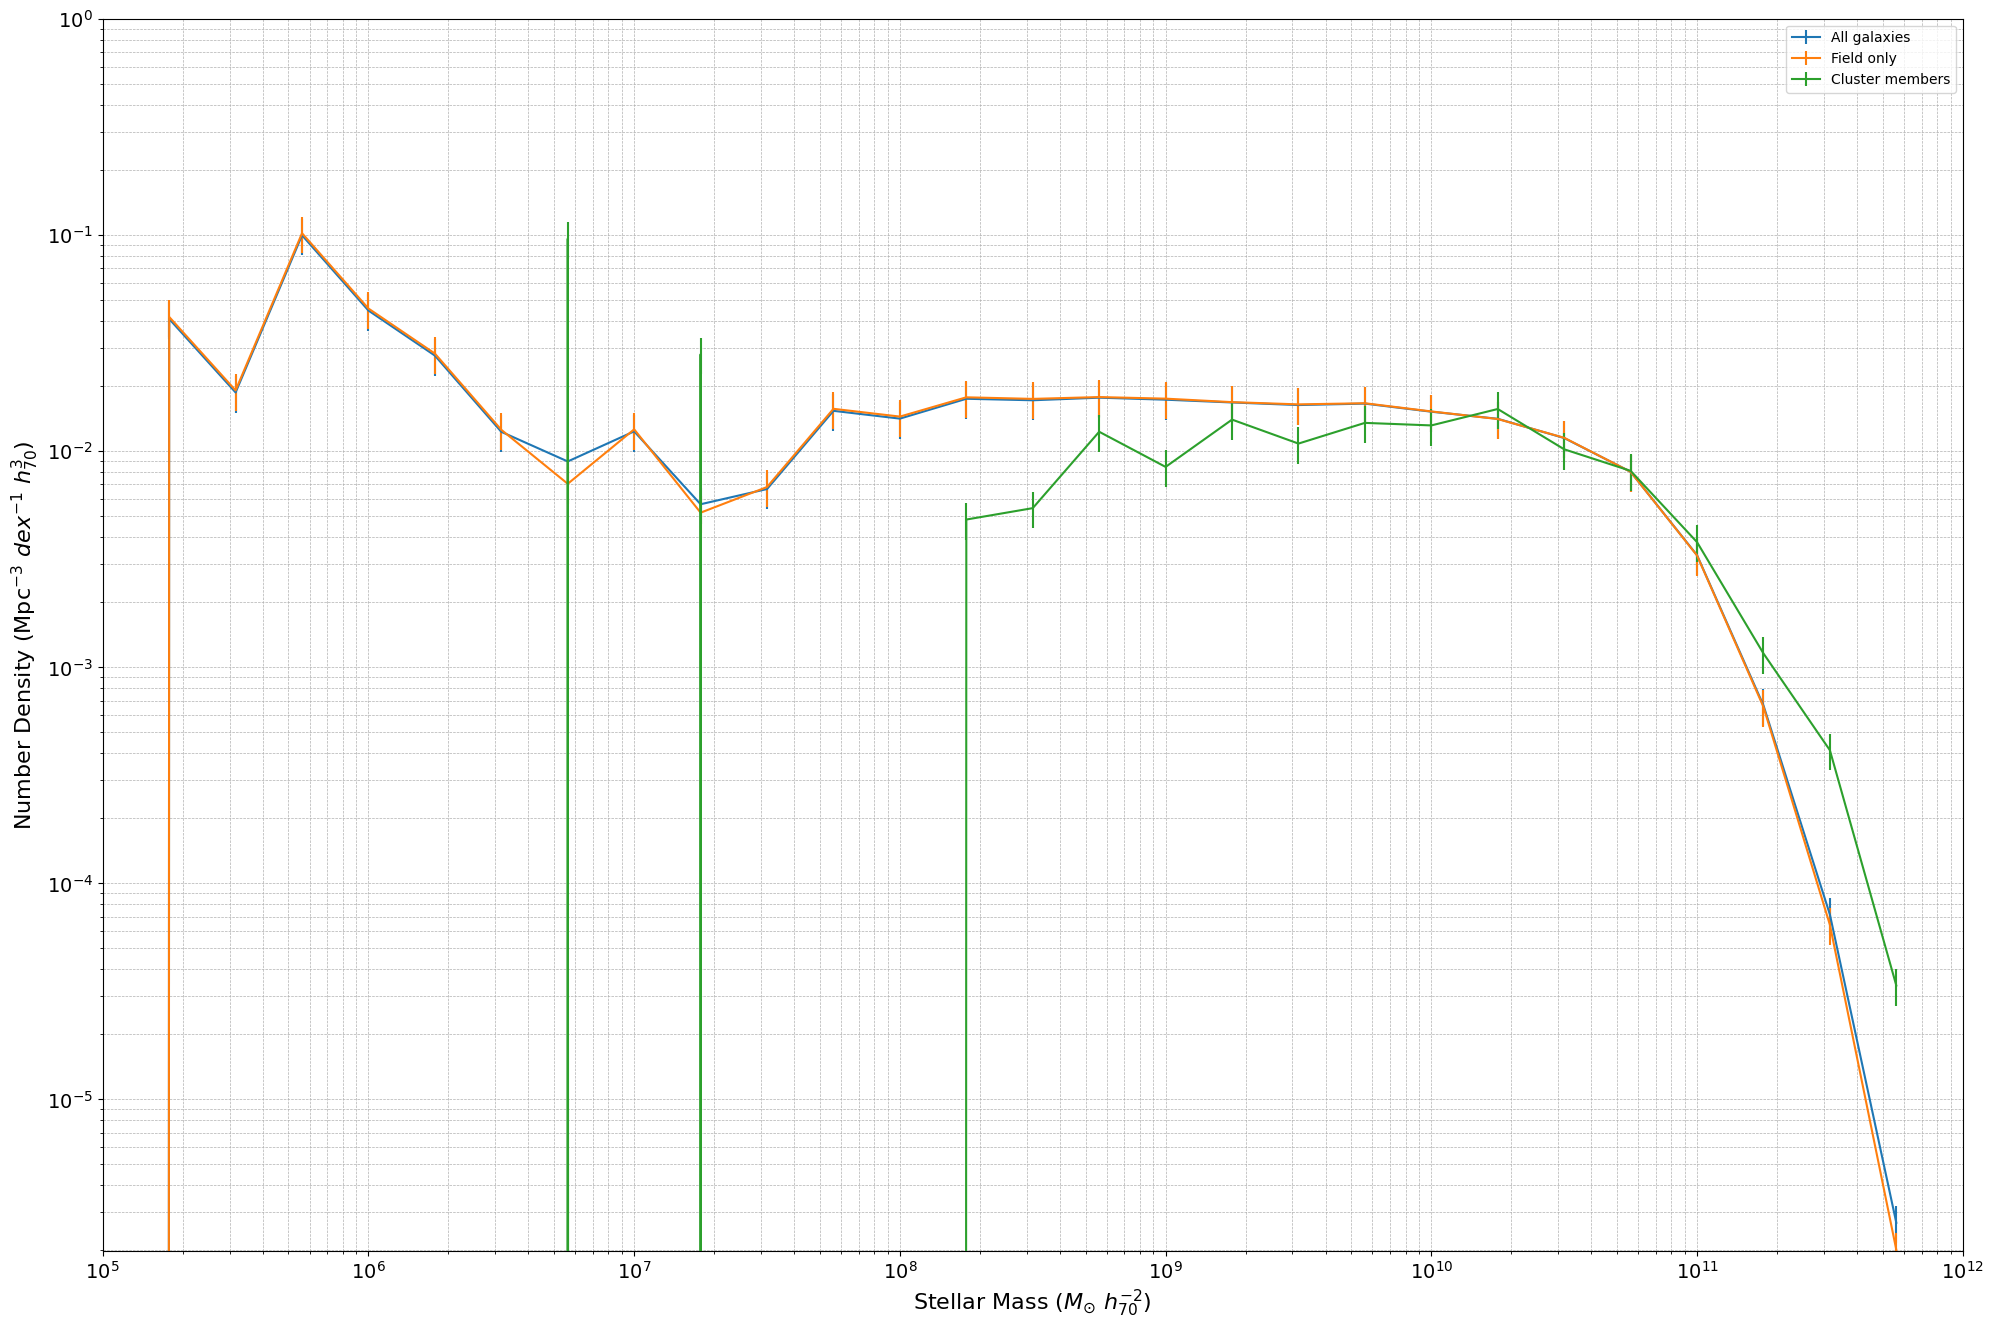

In [58]:
fig, ax = plt.subplots(figsize=(24, 16))

ratio_of_field_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "Field"]) / len(merged_galaxy_df)
ratio_of_cluster_galaxies = len(merged_galaxy_df[merged_galaxy_df["environment"] == "ClusterMember"]) / len(merged_galaxy_df)

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_all_galaxies,
    yerr=mass_histogram_all_galaxies_errors,
    label='All galaxies',
    )

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_field_only / ratio_of_field_galaxies,
    yerr=mass_histogram_field_only_errors / ratio_of_field_galaxies,
    label='Field only',
    )

plt.errorbar(
    MASS_BINS[:-1],
    mass_histogram_cluster_members / ratio_of_cluster_galaxies,
    yerr=mass_histogram_cluster_members_error / ratio_of_cluster_galaxies,
    label='Cluster members',
    )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)', fontsize=16)
plt.xlim((1e5, 1e12))
plt.ylim((10**-5.7, 1e0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [8]:
"""
matched galaxy data frame has uberID, RA, DEC, z, and environment (field or withing a cluster)
then separately we get the completeness for the mass of all the galaxies and merge it with the dataframe we have here
the dataframe will have: uberID, RA, DEC, z, Environment, completeness
we need to add the region (here G09) for each galaxy into the galaxy_dataframe columns
matched_galaxy_dataframe['region'] = 'G09'
then i feed all these columns as the input into mass_function:
mass_function_for_filed, mass_histogram_error_filed = get_weighted_mass_histogram(input_mass_completeness_dataframe=matched_galaxy_dataframe[matched_galaxy_dataframe['environment']=='field'], region_name= 'G09')
mass_function_for_within_clusters, mass_histogram_error_cluster = get_weighted_mass_histogram(input_mass_completeness_dataframe=matched_galaxy_dataframe[matched_galaxy_dataframe['environment']!='field'], region_name= 'G09')

then do the plotting
""" 

"\nmatched galaxy data frame has uberID, RA, DEC, z, and environment (field or withing a cluster)\nthen separately we get the completeness for the mass of all the galaxies and merge it with the dataframe we have here\nthe dataframe will have: uberID, RA, DEC, z, Environment, completeness\nwe need to add the region (here, 9) for each galaxy into the galaxy_dataframe columns\nmatched_galaxy_dataframe['region'] = 'G09'\nthen i feed all these columns as the input into mass_function:\nmass_function_for_filed, mass_histogram_error_filed = get_weighted_mass_histogram(input_mass_completeness_dataframe=matched_galaxy_dataframe[matched_galaxy_dataframe['environment']=='field'], region_name= 'G09')\nmass_function_for_within_clusters, mass_histogram_error_cluster = get_weighted_mass_histogram(input_mass_completeness_dataframe=matched_galaxy_dataframe[matched_galaxy_dataframe['environment']!='field'], region_name= 'G09')\n\nthen do the plotting\n"

In [43]:

# Find the clusters that have galaxies among them
unique_cluster_ids = matched_galaxy_dataframe['cluster_name'].unique()

# Print the clusters and their galaxies
cluster_galaxies = matched_galaxy_dataframe.groupby('cluster_name')['uberID'].apply(list).reset_index()
cluster_galaxies['num_galaxies'] = cluster_galaxies['uberID'].apply(len)

# Print the clusters with galaxies
for index, row in cluster_galaxies.iterrows():
    print(f"Cluster {row['cluster_name']} has the following {len(row['uberID'])} galaxies within: {row['uberID']}")

Cluster eFEDSJ083651.3+030002 has the following 2 galaxies within: [129020867111101, 129020874611193]
Cluster eFEDSJ083654.6+025954 has the following 19 galaxies within: [129020754611149, 129020765311309, 129020772711257, 129020773010920, 129020778211401, 129020789011021, 129020798811315, 129020805311478, 129020809511497, 129020813311435, 129020814211457, 129020818011458, 129020818111167, 129020818710946, 129020830411303, 129020830411211, 129020837511203, 129020843911386, 129020864311407]
Cluster eFEDSJ083723.6+012413 has the following 2 galaxies within: [129010249405188, 129010251405245]
Cluster eFEDSJ083802.9+015626 has the following 1 galaxies within: [129020496200495]
Cluster eFEDSJ083807.6+002501 has the following 6 galaxies within: [129000030605704, 129000034306108, 129000062305810, 130001047205365, 130001073105548, 130001116905236]
Cluster eFEDSJ083857.5+020846 has the following 1 galaxies within: [129020288502277]
Cluster eFEDSJ083858.5-015032 has the following 4 galaxies withi

In [44]:
# Find the maximum number of galaxies in a cluster
max_galaxies_row = cluster_galaxies.loc[cluster_galaxies['num_galaxies'].idxmax()]
print(f"Cluster {max_galaxies_row['cluster_name']} has the maximum number of galaxies: {max_galaxies_row['num_galaxies']}")

# Count the number of clusters with only one galaxy within them
clusters_with_one_galaxy = sum(cluster_galaxies['num_galaxies'] == 1)
print(f"Number of clusters with only one galaxy: {clusters_with_one_galaxy}")

Cluster eFEDSJ085027.8+001503 has the maximum number of galaxies: 54
Number of clusters with only one galaxy: 8


In [45]:
# Calculate the total number of galaxies within clusters
total_galaxies = cluster_galaxies['num_galaxies'].sum()
print(f"Total number of galaxies within clusters: {total_galaxies}")

Total number of galaxies within clusters: 969


In [46]:
# Find clusters with no galaxies
all_cluster_names = cluster_df['c_NAME'].unique()
clusters_with_galaxies = matched_galaxy_dataframe['cluster_name'].dropna().unique()
clusters_without_galaxies = np.setdiff1d(all_cluster_names, clusters_with_galaxies)

print(len(clusters_with_galaxies))
print("Clusters with no galaxies within:", len(clusters_without_galaxies))
for cluster_name in clusters_without_galaxies:
    print(f"Cluster name: {cluster_name}")

92
Clusters with no galaxies within: 70
Cluster name: eFEDSJ083503.2+010756
Cluster name: eFEDSJ083759.5-003643
Cluster name: eFEDSJ083806.9-003600
Cluster name: eFEDSJ083834.1+020643
Cluster name: eFEDSJ083900.6+020057
Cluster name: eFEDSJ083903.5-011454
Cluster name: eFEDSJ084006.1+025913
Cluster name: eFEDSJ084021.6+020132
Cluster name: eFEDSJ084051.7+014122
Cluster name: eFEDSJ084129.0+002645
Cluster name: eFEDSJ084135.0+010150
Cluster name: eFEDSJ084151.7+004351
Cluster name: eFEDSJ084220.9+013844
Cluster name: eFEDSJ084246.9-000917
Cluster name: eFEDSJ084324.2-001438
Cluster name: eFEDSJ084454.0+010021
Cluster name: eFEDSJ084459.2-011902
Cluster name: eFEDSJ084501.0+012728
Cluster name: eFEDSJ084545.2+005535
Cluster name: eFEDSJ084649.0+004946
Cluster name: eFEDSJ084833.2-012216
Cluster name: eFEDSJ084905.3+021435
Cluster name: eFEDSJ084939.6-005126
Cluster name: eFEDSJ085018.3+020018
Cluster name: eFEDSJ085121.2+012856
Cluster name: eFEDSJ085130.0-004609
Cluster name: eFEDSJ0852

In [47]:
print(1-44/162)


0.7283950617283951
